<h1 style="text-align:center;font-size:30px;" > Training For Damage Prediction </h1>

<p>The dataset consists of both categorial and numeric data. Therefore, preprocessing steps are 
applied on the dataset for convertng categorial variable to numberic data. Columns with higher with higher 
number of categorial variables are encoded using LabelEcnoder and other categorial variable with less than
20 categories are converted to one-hot encoding into different columns.</p>

<h2>1. Libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)

color = sns.color_palette()
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import seaborn as seabornInstance
%matplotlib inline
import json

<h2>2. Read Dataset</h2>

<h3>2.1 Using pandas pd.read_csv function the 'podatki.csv' dataset is loaded.</h3>

In [2]:
df = pd.read_csv("../raw-data/podatki.csv")  # Reading the dataset
 
print("Number of data points:",df.shape[0])  # printing row counts
print("Number of data features:",df.shape[1]) # printing feature count

# The below code stores the data type details of the dataset which we will used during testing phase
res = df.dtypes.to_frame('dtypes').reset_index()
# first create dictionary
d = res.set_index('index')['dtypes'].astype(str).to_dict()

with open('../variable-details/dataTypes.json', 'w') as f:
    json.dump(d, f)


Number of data points: 100000
Number of data features: 35


<h3>2.2 Generate schema for the raw dataset for creating table in docker postgresql</h3>

In [3]:
"Schema for raw table"
t= pd.io.sql.get_schema(df.reset_index(), 'data')
f= open("../postgres-docker/raw_data.sql","w+") # the .sql file is saved in the path "../postgres-docker/raw_data.sql"
f.write(t)

652

<h2>3 Visualising the dataset</h2>

In [4]:
df.head()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
0,10435088,6459234,4,2007,1998,G,G.8,G.8.3,F,?,...,-0.965540,-1.004587,-1.439141,-0.918689,N,-0.23153,-0.266117,-0.272337,-0.251419,0.0
1,2560445,1875568,1,2007,2004,BZ,BZ.11,BZ.11.2,B,A,...,-0.828755,-1.036169,-0.714171,-0.941224,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,5865974,4010054,4,2006,2003,Y,Y.42,Y.42.2,F,C,...,0.402303,-0.288724,-0.923061,-0.197237,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
3,1617366,922766,3,2006,1983,BW,BW.49,BW.49.1,H,?,...,-0.769284,0.182669,2.050541,-1.439512,N,-0.23153,-0.266117,2.715490,-0.251419,0.0
4,9914424,6289123,5,2005,1999,BW,BW.166,BW.166.0,I,C,...,0.503405,1.427241,0.932369,0.907092,M,-0.23153,-0.266117,4.209404,-0.251419,0.0


<h3>3.1 Displaying information about the datatypes and availability of null data</h3>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Row_ID          100000 non-null  int64  
 1   Household_ID    100000 non-null  int64  
 2   Vehicle         100000 non-null  int64  
 3   Calendar_Year   100000 non-null  int64  
 4   Model_Year      100000 non-null  int64  
 5   Blind_Make      100000 non-null  object 
 6   Blind_Model     100000 non-null  object 
 7   Blind_Submodel  100000 non-null  object 
 8   Cat1            100000 non-null  object 
 9   Cat2            100000 non-null  object 
 10  Cat3            100000 non-null  object 
 11  Cat4            100000 non-null  object 
 12  Cat5            100000 non-null  object 
 13  Cat6            100000 non-null  object 
 14  Cat7            100000 non-null  object 
 15  Cat8            100000 non-null  object 
 16  Cat9            100000 non-null  object 
 17  Cat10      

<h3> 3.3 Distribution of categories in different categorial variable</h3>
- This helps in deciding the cutoff to encoding variables. Columns with greater>20 values are suitable for converting into dummies and other categorial variables are processed using LabelEncoder

In [6]:
cols4dummies = []
cols4category = []
org_cols = list(df.columns)
for col in org_cols:
    if df[col].dtype== np.object:
        l = len(df[col].unique())
        print('Distinct values in column "',col,'" are ',l)
        if l<20:
            cols4dummies.append(col)
        else:
            cols4category.append(col)
            
print('\nColumns we can convert to dummies:\n',cols4dummies)  
print('\nColumns we can convert to categories:\n',cols4category)

Distinct values in column " Blind_Make " are  64
Distinct values in column " Blind_Model " are  1000
Distinct values in column " Blind_Submodel " are  2004
Distinct values in column " Cat1 " are  11
Distinct values in column " Cat2 " are  4
Distinct values in column " Cat3 " are  7
Distinct values in column " Cat4 " are  4
Distinct values in column " Cat5 " are  4
Distinct values in column " Cat6 " are  6
Distinct values in column " Cat7 " are  5
Distinct values in column " Cat8 " are  4
Distinct values in column " Cat9 " are  2
Distinct values in column " Cat10 " are  4
Distinct values in column " Cat11 " are  7
Distinct values in column " Cat12 " are  7
Distinct values in column " OrdCat " are  8
Distinct values in column " NVCat " are  15

Columns we can convert to dummies:
 ['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'OrdCat', 'NVCat']

Columns we can convert to categories:
 ['Blind_Make', 'Blind_Model', 'Blind_Submodel']


<h3>3.4 Ploting the Claim_Amount</h3>

Maximum number of times a Claim_Amount is repeated: 99282



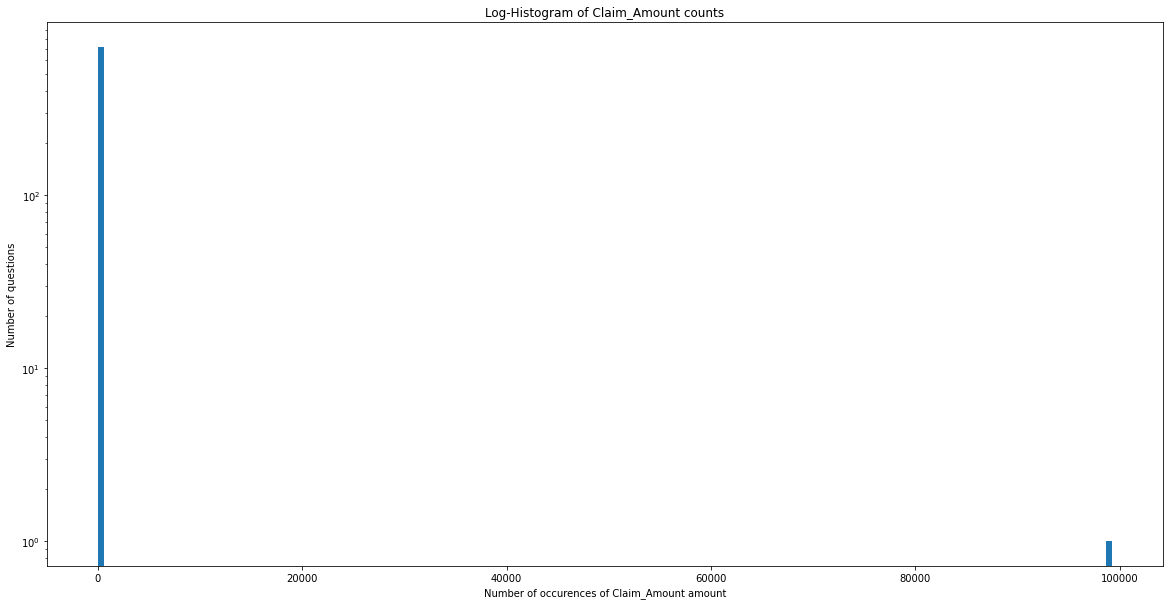

In [7]:
plt.figure(figsize=(20, 10))
plt.hist(df['Claim_Amount'].value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Claim_Amount counts')
plt.xlabel('Number of occurences of Claim_Amount amount')
plt.ylabel('Number of questions')
print ('Maximum number of times a Claim_Amount is repeated: {}\n'.format(max(df['Claim_Amount'].value_counts()))) 

<h2>4. Preprocessing Categorial Columns</h2>
- converting columns into dummies which have categoris less than 20

In [8]:
df = pd.get_dummies(df, columns=cols4dummies)

<h3>4.1 Columns count after dummification</h3>


In [9]:
print('After getting dummies columns')
print("Number of data points:",df.shape[0])
print("Number of data features:",df.shape[1])

After getting dummies columns
Number of data points: 100000
Number of data features: 108


<h3>4.2 Converting larger categorial variables using Label encoder and saving the encoders as .pkl file</h3>


In [10]:
#https://stackoverflow.com/questions/28656736/using-scikits-labelencoder-correctly-across-multiple-programs

le = LabelEncoder()   
for col in cols4category:
    df[col] = le.fit_transform(df[col])
#exporting the departure encoder
    output = open('../encoder-files/'+col+'.pkl', 'wb')
    pickle.dump(le, output)
    output.close()

<h3>4.3 Columns count after Label Encoder is not changed</h3>


In [11]:
print('After getting dummies columns')
print("Number of data points:",df.shape[0])
print("Number of data features:",df.shape[1])

After getting dummies columns
Number of data points: 100000
Number of data features: 108


In [12]:
for col in df.columns:
    if df[col].dtype== np.object:
        l = len(df[col].unique())
        print('Distinct values in column "',col,'" are ',l)

In [13]:
df.head()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Var1,Var2,...,NVCat_F,NVCat_G,NVCat_H,NVCat_I,NVCat_J,NVCat_K,NVCat_L,NVCat_M,NVCat_N,NVCat_O
0,10435088,6459234,4,2007,1998,45,702,1271,-1.059611,-0.816152,...,0,0,0,0,0,0,0,0,1,0
1,2560445,1875568,1,2007,2004,41,662,1203,-0.770352,-1.179266,...,0,0,0,0,0,0,0,1,0,0
2,5865974,4010054,4,2006,2003,62,979,1976,-0.119519,-0.124506,...,0,0,0,0,0,0,0,1,0,0
3,1617366,922766,3,2006,1983,39,624,1137,-0.159693,-0.470329,...,0,0,0,0,0,0,0,0,1,0
4,9914424,6289123,5,2005,1999,39,595,1098,0.442930,1.172330,...,0,0,0,0,0,0,0,1,0,0


<h3>4.3 Drop columns such Row_ID and Household_ID which are unique identifies as 
they are not usefull for predicition</h3>


In [14]:
df.drop(['Row_ID','Household_ID'], axis=1, inplace=True)

In [15]:
print('After getting dummies columns')
print("Number of data points:",df.shape[0])
print("Number of data features:",df.shape[1])

After getting dummies columns
Number of data points: 100000
Number of data features: 106


<h3>4.4 Save Schema of the processed dataset for creating table in database</h3>


In [16]:
"Schema for raw table"
t= pd.io.sql.get_schema(df.reset_index(), 'data')
f= open("../postgres-docker/pocessed_data.sql","w+")
f.write(t)

2187

<h2>5 Split into Train(80%) and Test(20%)</h2>


In [17]:

train_df, val_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

train_df,test_df,class_train,class_test  = train_test_split(df.loc[:, df.columns != 'Claim_Amount'],df['Claim_Amount'],test_size=0.2,train_size=0.8,random_state = 0)


In [18]:
print('Train data:',train_df.shape," ", len(train_df)/len(df))
print('Test data:',test_df.shape," ",len(test_df)/len(df))

Train data: (80000, 105)   0.8
Test data: (20000, 105)   0.2


In [19]:
res = train_df.dtypes.to_frame('dtypes').reset_index()
# first create dictionary
d = res.set_index('index')['dtypes'].astype(str).to_dict()

with open('../variable-details/TrainDataTypes.json', 'w') as f:
    json.dump(d, f)

In [20]:
df.to_csv("../train-test-data/Processed_data.csv")

<h2>6 Fit Random Forest Model and save the trained model for testing</h2>


In [48]:
#https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)# Train the model on training data
rf.fit(train_df, class_train)
pickle.dump(rf, open('../saved-model/RandomForestModel.sav', 'wb'))

In [49]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_df)# Calculate the absolute errors
errors = abs(predictions - class_test)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')#

Mean Absolute Error: 3.5 degrees.
